In [1]:
# If You use in Colab, You Should run this script
import os
if (not os.path.exists("./SSD-object-detection") and
    not "SSD-object-detection" in os.getcwd()):
    !git clone https://github.com/pai-sj/SSD-object-detection.git
    os.chdir("./SSD-object-detection")

In [2]:
%matplotlib inline

import sys
sys.path.append("../")
from utils import DetectionDataset, draw_rectangle
from models.generator import DetectionGenerator, PriorBoxes, calculate_iou
from models.ssd import build_base_network, attach_multibox_head
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

np.random.seed(10)
tf.random.set_random_seed(10)

In [3]:
# 데이터 가져오기
strides = [4, 8, 16]
scales = [10, 25, 40]
ratios = [(1,1),     # ratio : 1.
          (0.5,1.5), # ratio : 0.33
          (0.8,1.2), # ratio : 0.67
          (1.2,0.8), # ratio : 1.5
          (1.4,1.4)]

prior = PriorBoxes(strides,scales,ratios)

trainset = DetectionDataset(data_type='train')
validset = DetectionDataset(data_type='validation')

traingen = DetectionGenerator(trainset, 
                              prior.config, 
                              batch_size=64)
validgen = DetectionGenerator(validset, 
                              prior.config, 
                              batch_size=64)

In [4]:
# 기존 모델 가져오기
model = load_model('../samples/pretrained_ssd.h5',compile=False)

W0730 18:40:56.884845 4546049472 deprecation.py:506] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0730 18:40:56.887237 4546049472 deprecation.py:506] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0730 18:40:56.888417 4546049472 deprecation.py:506] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init

# \[ 모델 개선하기 \]
----
----

Single Shot Multi Detector가 등장 이후, 후속 연구들이 이어서 진행되었습니다. 다양한 요소들에 있어 점진적인 개선이 이루어졌는데, 이를 살펴보도록 하겠습니다. <br>

가장 간단하게 적용할 수 있는 것부터 시작해보도록 하겠습니다.

## 1. Non-Maximum Suppression 알고리즘 바꾸기
---

[Soft-NMS : Improving Object Detection With One Line of Code](https://arxiv.org/pdf/1704.04503.pdf)는 기존의 NMS 알고리즘이 가지고 있는 문제를 개선한 논문입니다. 2017년에 공개되어, 이후 많은 연구자들이 Soft-NMS를 사용하기 시작하였습니다.

![Imgur](https://i.imgur.com/B6s5YrS.png)

Soft NMS가 던지고 있는 질문은 위와 같은 케이스입니다. 사물이 **정말로** 포개져 있는 경우에, NMS를 적용하면 오히려 잘못된 결과를 반환한다는 것입니다.

![Imgur](https://i.imgur.com/g59aVNi.png)



이걸 개선하는 방법은 매우 간단합니다. 
> **한 줄만 바꾸자, 빨간 색 지우고 초록색 줄로.**

논문 저자들은 자신의 코드를 깃헙에 게재하였고, 아래는 Cython으로 짜여져 있는 코드를 Python Numpy Vectorization으로 변환시킨 코드입니다.
[soft-nms : github](https://github.com/bharatsingh430/soft-nms/blob/master/lib/nms/cpu_nms.pyx)

In [5]:
def soft_non_maximum_suppression(boxes, confs, score_threshold=0.5):
    pick = []
    cx, cy, w, h = boxes.T
    x1, x2 = cx - w / 2, cx + w / 2
    y1, y2 = cy - h / 2, cy + h / 2

    indices = np.argsort(confs)[::-1]
    area = (x2 - x1) * (y2 - y1)

    scores = confs.copy()
    while len(indices) > 0:
        idx, indices = indices[0], indices[1:]
        pick.append(idx)

        xx1 = np.maximum(x1[idx], x1[indices])
        yy1 = np.maximum(y1[idx], y1[indices])
        xx2 = np.minimum(x2[idx], x2[indices])
        yy2 = np.minimum(y2[idx], y2[indices])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        intersection = w * h
        union = area[indices] + area[idx] - intersection
        overlap = intersection / (union + 1e-8)

        scores[indices] = scores[indices] * np.exp(-overlap ** 2 / 0.5)
    pick = np.where(scores > score_threshold)[0]
    return pick

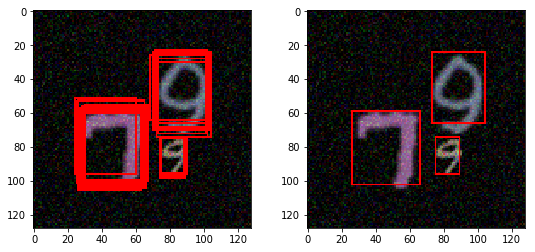

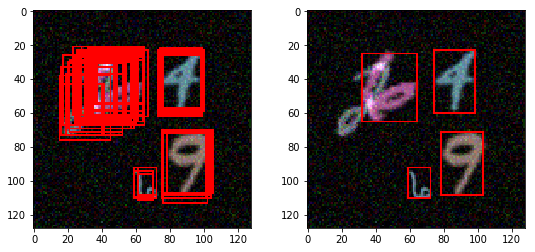

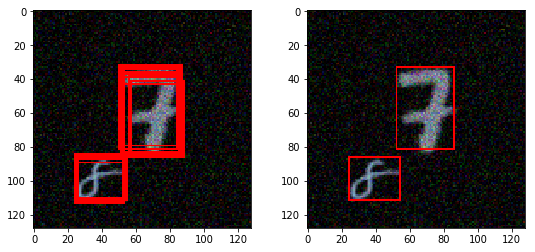

In [6]:
images, labels = validgen[0]
predictions = model.predict(images)

for idx, image in enumerate(images[:3]):
    pred_loc = predictions[idx,:,-4:]
    pred_clf = predictions[idx,:,:-4]
    pr_boxes = prior.generate(images[0].shape)

    # 예측값을 bounding Box 값(cx,cy,w,h)으로 복원하기
    res_cx = (pred_loc[:,0] 
              * pr_boxes[:,2] 
              + pr_boxes[:,0])
    res_cy = (pred_loc[:,1] 
              * pr_boxes[:,3] 
              + pr_boxes[:,1])
    res_w = (np.exp(pred_loc[:,2])
             *pr_boxes[:,2])
    res_h = (np.exp(pred_loc[:,3])
             *pr_boxes[:,3])
    restore_boxes = np.stack([res_cx,res_cy,res_w,res_h],
                             axis=-1)
    
    bg_index = pred_clf.shape[-1]-1
    fg_indices = np.argwhere(pred_clf.argmax(axis=1)!=bg_index)
    
    restore_boxes = restore_boxes[fg_indices].squeeze()
    pred_clf = pred_clf[fg_indices]
    pred_scores = pred_clf.max(axis=-1)
    pred_scores = pred_scores.squeeze()
    
    # NMS 적용
    pick_indices = soft_non_maximum_suppression(restore_boxes, 
                                                pred_scores,
                                                0.3)
    chosen_boxes = restore_boxes[pick_indices]
    
    before_nms = draw_rectangle(images[idx], restore_boxes)    
    after_nms = draw_rectangle(images[idx], chosen_boxes)
    fig = plt.figure(figsize=(9,4))
    ax = fig.add_subplot(1,2,1)
    ax.imshow(before_nms)
    ax = fig.add_subplot(1,2,2)
    ax.imshow(after_nms)
    plt.show()

## 2. Matching Strategy 바꾸기
---

[RetinaMask: Learning to predict masks imporvew state-of-the-art single-shot detection for free](https://arxiv.org/pdf/1901.03353.pdf)은 19년도에 만들어진 논문으로, SSD 계통에서 State-Of-The-Art Model입니다. SSD 모델에 다양한 변경을 가했지만, 이중 Matching Strategy에 집중해보도록 하겠습니다.<br>

위 논문에서 Matching strategy 에 대한 설명입니다.

````markdown
All Anchor boxes that have an intersection-over-union(IOU) overlap with a ground truth object greater than 0.5, are considered positive examples. If the overlap is less than 0.4, the anchor boxes are assigned a negative label. All anchors for which the overlap falls between 0.4 and 0.5 are not used in the training. However, there exists an exceptional  ase for which the assignment can be imporved. Specifically, some of the ground thruth objects' aspect ratios are outliers, with one side much longer than the other. Thus, no anchor box can be matched to those according to the RetinaNet strategy. For each of these ground truth boxes we propose to find its best matching anchor box, relaxing the overlapping IOU threshold. We provide an ablation study using different thresholds on the best matching sanchor with any nonzero overlap given the best accuracy(notice that such anchors always exists, because single-shot anchors are densely sampled).
````

위를 정리하면 아래처럼 표현할 수 있습니다.

1. **애매한 것은 제거하자!** : (IOU가 0.4이상 0.5 이하는 Background로 보기도 애매, foreground로 보기도 애매하다)
2. **누락된 것은 포함시키자!** : (모든 사물 박스에 대한 IOU Max는 포함시키자!)

기존의 Matching Algorithm은 아래와 같습니다.

In [7]:
num_classes = 10
images, ground_truths = validset[0:1]
pr_boxes = prior.generate(images.shape[1:])

y_true = []
for index, gt_df in ground_truths.groupby('image_index'):
    gt_boxes = gt_df[['cx', 'cy', 'w', 'h']].values
    gt_labels = gt_df['label'].values
    iou = calculate_iou(gt_boxes, pr_boxes)
    
    ##### 매칭 알고리즘 >>>>>> 
    match_indices = np.argwhere(iou >= 0.5)
    ##### <<<<<<< 매칭 알고리즘
    gt_match_indices = match_indices[:, 0]
    pr_match_indices = match_indices[:, 1]

    # Background로 일단 채움
    y_true_clf = np.ones((pr_boxes.shape[0])) * num_classes
    y_true_clf[pr_match_indices] = gt_labels[gt_match_indices]

    # classification One-Hot Encoding
    y_true_clf = to_categorical(y_true_clf,
                                num_classes=num_classes + 1)

    # Positional Information Encoding
    y_true_loc = np.zeros((pr_boxes.shape[0], 4))
    g_cx, g_cy, g_w, g_h = gt_boxes[gt_match_indices].transpose()
    p_cx, p_cy, p_w, p_h = pr_boxes[pr_match_indices].transpose()

    hat_g_cx = (g_cx - p_cx) / p_w
    hat_g_cy = (g_cy - p_cy) / p_h
    hat_g_w = np.log(g_w / p_w)
    hat_g_h = np.log(g_h / p_h)

    hat_g = np.stack([hat_g_cx, hat_g_cy, hat_g_w, hat_g_h], axis=1)
    y_true_loc[pr_match_indices] = hat_g

    y_true_head = np.concatenate([y_true_clf, y_true_loc], axis=1)

    y_true.append(y_true_head)

best matching Policy는 간단히 아래처럼 변경할 수 있습니다.

In [8]:
num_classes = 10
images, ground_truths = validset[0:1]
pr_boxes = prior.generate(images.shape[1:])

y_true = []
for index, gt_df in ground_truths.groupby('image_index'):
    gt_boxes = gt_df[['cx', 'cy', 'w', 'h']].values
    gt_labels = gt_df['label'].values
    iou = calculate_iou(gt_boxes, pr_boxes)
    
    ##### 변경된 매칭 알고리즘 >>>>>> 
    best_indices = np.stack([np.arange(iou.shape[0]),
                             np.argmax(iou,axis=1)],axis=1)
    match_indices = np.argwhere(iou >= 0.5)
    match_indices = np.concatenate([match_indices, best_indices])
    ignore_indices = np.argwhere((iou > 0.4)&(iou <= 0.5))[:, ]
    ##### <<<<<<< 변경된 매칭 알고리즘
    gt_match_indices = match_indices[:, 0]
    pr_match_indices = match_indices[:, 1]

    # Background로 일단 채움
    y_true_clf = np.ones((pr_boxes.shape[0])) * num_classes
    y_true_clf[pr_match_indices] = gt_labels[gt_match_indices]

    # classification One-Hot Encoding
    y_true_clf = to_categorical(y_true_clf,
                                num_classes=num_classes + 1)
    ##### 변경된 매칭 알고리즘 >>>>>> 
    y_true_clf[ignore_indices] = -1 # y_true_clf에 -1을 넣어서 ignore을 표시
    ##### <<<<<<< 변경된 매칭 알고리즘    

    # Positional Information Encoding
    y_true_loc = np.zeros((pr_boxes.shape[0], 4))
    g_cx, g_cy, g_w, g_h = gt_boxes[gt_match_indices].transpose()
    p_cx, p_cy, p_w, p_h = pr_boxes[pr_match_indices].transpose()

    hat_g_cx = (g_cx - p_cx) / p_w
    hat_g_cy = (g_cy - p_cy) / p_h
    hat_g_w = np.log(g_w / p_w)
    hat_g_h = np.log(g_h / p_h)

    hat_g = np.stack([hat_g_cx, hat_g_cy, hat_g_w, hat_g_h], axis=1)
    y_true_loc[pr_match_indices] = hat_g

    y_true_head = np.concatenate([y_true_clf, y_true_loc], axis=1)

    y_true.append(y_true_head)

위의 것들을 시각화 하면 아래와 같습니다.

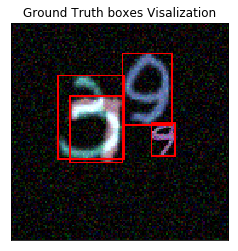

In [9]:
target_indices = match_indices
visualized = draw_rectangle(images[0], gt_boxes[target_indices[:,0]],
                            color=(255,0,0))
plt.title("Ground Truth boxes Visalization")
plt.xticks([])
plt.yticks([])
plt.imshow(visualized)
plt.show()

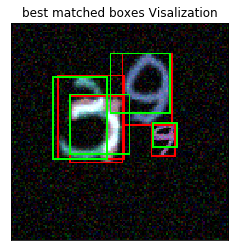

In [10]:
target_indices = match_indices
visualized = draw_rectangle(visualized, pr_boxes[best_indices[:,1]],
                            color=(0,255,0))
plt.title("best matched boxes Visalization")
plt.xticks([])
plt.yticks([])
plt.imshow(visualized)
plt.show()

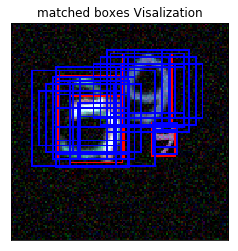

In [11]:
target_indices = match_indices
visualized = draw_rectangle(visualized, pr_boxes[match_indices[:,1]],
                            color=(0,0,255))
plt.title("matched boxes Visalization")
plt.xticks([])
plt.yticks([])
plt.imshow(visualized)
plt.show()

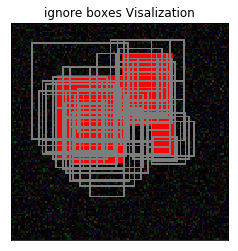

In [12]:
target_indices = match_indices
visualized = draw_rectangle(images[0], gt_boxes[target_indices[:,0]],
                            color=(255,0,0),thickness=-1)
visualized = draw_rectangle(visualized, pr_boxes[ignore_indices[:,1]],
                            color=(125,125,125))
plt.title("ignore boxes Visalization")
plt.xticks([])
plt.yticks([])
plt.imshow(visualized)
plt.show()

위에서 표시한 Ignore Value는 Loss값 계산에서 이용합니다. 

ignore match의 경우, `y_true_clf[:, -1]`의 값이 {0,1}이 아닌 -1으로 채워져 있습니다. `y_true_clf`의 경우, 이후 softmax 계산할 때 값이 {0,1}사이에 매칭되지 않은 경우,
NaN을 반환하기 때문에, `y_true_clf` 내 ignore match된 값들을 다시 1로 바꾸어줍니다.


In [15]:
def ssd_loss(y_true, y_pred):
    num_classes = tf.shape(y_true)[2] - 4
    y_true = tf.reshape(y_true, [-1, num_classes + 4])
    y_pred = tf.reshape(y_pred, [-1, num_classes + 4])
    eps = K.epsilon()

    # Split Classification and Localization output
    y_true_clf, y_true_loc = tf.split(y_true, [num_classes, 4], axis=-1)
    y_pred_clf, y_pred_loc = tf.split(y_pred, [num_classes, 4], axis=-1)

    # split foreground & background
    mask = y_true_clf[:, -1]

    # >>>>>>>>>>>> 변경사항
    neg_mask = tf.where(tf.equal(mask, 1.),
                        tf.ones_like(mask),
                        tf.zeros_like(mask)) 
    pos_mask = tf.where(tf.equal(mask, 0.),
                        tf.ones_like(mask),
                        tf.zeros_like(mask)) 
    y_true_clf = tf.where(tf.not_equal(y_true_clf, 0),
                          tf.ones_like(y_true_clf),
                          tf.zeros_like(y_true_clf))
    # <<<<<<<<<<<< 변경사항
    num_pos = tf.reduce_sum(pos_mask)
    num_neg = tf.reduce_sum(neg_mask)
    num_neg = tf.minimum(pos_neg_ratio * num_pos, num_neg)

    # softmax loss
    y_pred_clf = K.clip(y_pred_clf, eps, 1. - eps)
    clf_loss = -tf.reduce_sum(y_true_clf * tf.log(y_pred_clf),
                              axis=-1)
    pos_clf_loss = tf.reduce_sum(clf_loss * pos_mask) / (num_pos + eps)
    neg_clf_loss = clf_loss * neg_mask
    values, indices = tf.nn.top_k(neg_clf_loss,
                                  k=tf.cast(num_neg, tf.int32))
    neg_clf_loss = tf.reduce_sum(values) / (num_neg + eps)

    clf_loss = pos_clf_loss + neg_clf_loss
    # smooth l1 loss
    l1_loss = tf.abs(y_true_loc - y_pred_loc)
    l2_loss = 0.5 * (y_true_loc - y_pred_loc) ** 2
    loc_loss = tf.where(tf.less(l1_loss, 1.0),
                        l2_loss,
                        l1_loss - 0.5)
    loc_loss = tf.reduce_sum(loc_loss, axis=-1)
    loc_loss = tf.reduce_sum(loc_loss * pos_mask) / (num_pos + eps)

    # total loss
    return clf_loss + alpha * loc_loss

## 3. Network 구조 바꾸기
---

[Feature Pyramid networks for object detection](https://zpascal.net/cvpr2017/Lin_Feature_Pyramid_Networks_CVPR_2017_paper.pdf)은 Object Detection 논문 계통에서 중요한 지위를 차지하는 논문입니다. Multi-Scale의 문제를 매우 간단한 방법으로 해결하였습니다.

![Imgur](https://i.imgur.com/COidfr6.png)

Convolution을 거칠수록 우리는 **더 넓은 영역**, 그리고 **더 추상화된 정보**를 얻을 수 있습니다. 이러한 정보를 얕은 층의 Detection에도 포함시키면 어떨까요? 바로 위층의 정보를 다시금 아래층으로 넣어주자는 아이디어가 바로 Feature Pyramid Network입니다.

현재 우리의 네트워크에 적용하자면 아래와 같습니다.

![Imgur](https://i.imgur.com/AFBt8A5.png)

In [16]:
from tensorflow.keras.layers import UpSampling2D, Conv2D, Add

In [17]:
K.clear_session()

base_network = build_base_network()

# Feature Pyramid Network 수식
num_features = 64
layer_names = ['norm3_2','norm4_2','norm5_2']

upsampled = None

pyramid_outputs = []
for idx, layer_name in enumerate(layer_names):
    source_layer = base_network.get_layer(layer_name).output

    lateral = Conv2D(num_features, (1,1), padding='same')(source_layer)
    if upsampled is not None:
        output = Add()([lateral, upsampled])
    else:
        output = lateral
        upsampled = UpSampling2D((2,2))(lateral)
    p_num = len(layer_names)-idx        
    pyramid_output = Conv2D(num_features,(3,3),
                            padding='same',name=f'P{p_num}')(output)
    pyramid_outputs.append(pyramid_output)
    
fpn_network = Model(base_network.input,pyramid_outputs)    

위를 메소드로 구현하면 아래와 같습니다.

In [18]:
def remodel_fpn_network(base_network, source_layer_names, num_features=64):
    upsampled = None

    pyramid_outputs = []
    num_layer = len(source_layer_names)
    for idx, layer_name in enumerate(source_layer_names):
        source_layer = base_network.get_layer(layer_name).output

        lateral = Conv2D(num_features, (1, 1), padding='same')(source_layer)
        if upsampled is not None:
            output = lateral + upsampled
        else:
            output = lateral
            upsampled = UpSampling2D((2, 2))(lateral)
        p_num = num_layer - idx
        pyramid_output = Conv2D(num_features, (3, 3),
                                padding='same', name=f'P{p_num}')(output)
        pyramid_outputs.append(pyramid_output)

    fpn_network = Model(base_network.input, pyramid_outputs)
    return fpn_network


위의 메소드를 구현하면 우리는 단 한 줄의 추가로 모델의 구조를 바꿀 수 있습니다.

In [19]:
K.clear_session()

base_network = build_base_network()
# >>>>>>>>>>
fpn_network = remodel_fpn_network(base_network, 
                                  ['norm3_2','norm4_2','norm5_2'])
# <<<<<<<<<<
predictions = attach_multibox_head(fpn_network, ['P1','P2','P3'])
ssd = Model(fpn_network.input,predictions)

## 4. Loss Function 바꾸기
---

[Focal Loss For Dense Object Detection](http://openaccess.thecvf.com/content_ICCV_2017/papers/Lin_Focal_Loss_for_ICCV_2017_paper.pdf)은 Focal Loss라 불리는 새로운 Loss식을 제안한 논문입니다. 이때까지 이용하였던, Hard Negative Sampling 방법 대신 이용할 수 있는 방법론으로, Loss 식을 바꾸는 것 만으로도 성능이 크게 개선되었습니다.

![Imgur](https://i.imgur.com/N8uYvPx.png)

모델이 학습될때 제일 큰 문제 중 하나는 바로 Class Imbalance라고 불리는 문제입니다. Detection의 Classifier는 수많은 Prior Box 중에서 Background와 Object를 분류하는 데에 초점을 두고 있습니다. 하지만 Background와 Object의 비율은 1000:1이 넘으므로, 너무 많은 Background가 존재합니다. 그러다 보니, 모델은 Background을 위주로만 학습하다 보니, 되려 중요한 Object의 정보는 학습을 잘 하지 못합니다. 이러한 현상을 막고자, SSD는 이때까지 Hard Negative Sampling이라는 방법을 도입하여, 배경 이미지 중 Loss값이 높은 것들만 선별하여 학습하였습니다.

![Imgur](https://i.imgur.com/A7ESLnK.png)

이는 학습하는 데에 어렵스

$$
p_t = \begin{cases}
p && \mbox{if y = 1} \\
1-p && \mbox{otherwise,}
\end{cases} \\
FL(p_t) = - \alpha_t(1-p_t)^\gamma log(p_t).
$$

Classifica

In [20]:
def focal_loss(y_true, y_pred):
    num_classes = tf.shape(y_true)[2] - 4
    y_true = tf.reshape(y_true, [-1, num_classes + 4])
    y_pred = tf.reshape(y_pred, [-1, num_classes - 1 + 4])
    eps = K.epsilon()

    # Split Classification and Localization output
    y_true_clf, y_true_loc = tf.split(y_true, [num_classes, 4], axis=-1)
    y_pred_clf, y_pred_loc = tf.split(y_pred, [num_classes - 1, 4], axis=-1)

    # split foreground & background
    mask = y_true_clf[:, -1]
    ignore_mask = tf.where(tf.equal(mask, -1.),
                           tf.zeros_like(mask),
                           tf.ones_like(mask))
    neg_mask = tf.where(tf.equal(mask, 1.),
                        tf.ones_like(mask),
                        tf.zeros_like(mask))
    pos_mask = tf.where(tf.equal(mask, 0.),
                        tf.ones_like(mask),
                        tf.zeros_like(mask))
    y_true_clf = tf.where(tf.not_equal(y_true_clf, 0),
                          tf.ones_like(y_true_clf),
                          tf.zeros_like(y_true_clf))
    num_pos = tf.reduce_sum(pos_mask)
    num_neg = tf.reduce_sum(neg_mask)

    # Focal Loss
    y_pred_clf = K.clip(y_pred_clf, eps, 1. - eps)
    pt = tf.where(tf.equal(y_true_clf[:, :num_classes - 1], 1.),
                  y_pred_clf, 1. - y_pred_clf)
    loss = -K.pow(1. - pt, gamma) * tf.log(pt)
    clf_loss = tf.reduce_sum(alpha * loss, axis=-1)
    clf_loss = tf.reduce_sum(ignore_mask * clf_loss) / (num_pos + num_neg + eps)

    # smooth l1 loss
    l1_loss = tf.abs(y_true_loc - y_pred_loc)
    l2_loss = 0.5 * (y_true_loc - y_pred_loc) ** 2
    loc_loss = tf.where(tf.less(l1_loss, 1.0),
                        l2_loss,
                        l1_loss - 0.5)
    loc_loss = tf.reduce_mean(loc_loss, axis=-1)
    loc_loss = tf.reduce_sum(loc_loss * pos_mask) / (num_pos + eps)

    # total loss
    return alpha * clf_loss + loc_loss